<a href="https://colab.research.google.com/github/polyamuscat/ColabLabs/blob/main/LabTimeSeriesDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


Прежде чем начать, убедитесь, что вы используете Python 3 и GPU. В пункте меню *RunTime->Change runtime type* установите нужные параметры. 

Часть кода потребует установки последней версии TensoFlow 2.х. Поэтому убедитесь, что она у вас установлена, запустив ячейку ниже. Если у вас стоит версия Tensorflow 1.х - запустите ячейку сверху этого текста. Если вы это сделете и увидите сообщение о перезапуске runtime, - перезапустите. Убедитесь еще раз, что у вас все еще включены опции Python 3 и GPU, и снова запустите ячейку ниже. В результате вы должны увидеть, что теперь установлен TensoFlow 2.х .

In [2]:
import tensorflow as tf
print(tf.__version__)


2.5.0


Следующий блок кода содержит много того, что вы видели на предыдущих уроках. Он создаст временной ряд `series` с трендом, сезонностью и шумом. Вы увидите этот синтетический временной ряд на графике.

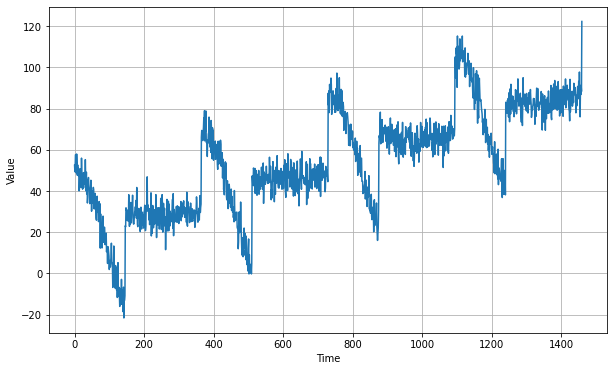

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")

series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [5]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [21]:
window_size = 10
batch_size = 32
shuffle_buffer_size = 1000

In [22]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, input_shape=[window_size], activation='relu'),
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(1, activation='relu')                                    
])

In [23]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * (10 ** (epoch / 20)))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks = [lr_schedule], verbose=0)

(1e-08, 0.001, 0.0, 300.0)

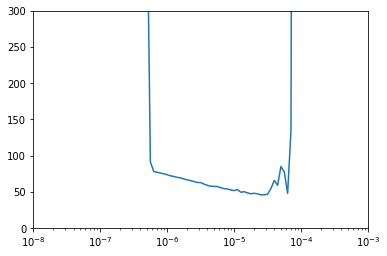

In [24]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20)) 
plt.semilogx(lrs, history.history['loss'])
plt.axis([1e-8, 1e-3, 0, 300])

In [31]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, input_shape=[window_size], activation='relu'),
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(1, activation='relu')                                    
])
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=0)

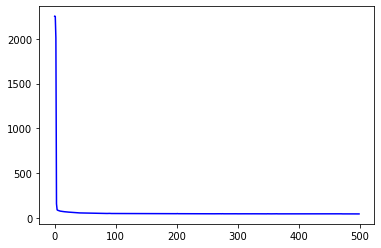

In [32]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.show()

[73.09847259521484, 71.49281311035156, 70.4295883178711, 69.7677001953125, 68.48574829101562, 67.43985748291016, 66.96794128417969, 66.17420959472656, 65.26326751708984, 64.74679565429688, 64.3605728149414, 63.51982116699219, 63.050025939941406, 62.4340934753418, 61.873409271240234, 62.13001251220703, 61.303245544433594, 60.19297409057617, 59.619834899902344, 59.16032028198242, 58.93893051147461, 58.350337982177734, 57.85335922241211, 57.35877990722656, 57.27009582519531, 56.626922607421875, 55.670494079589844, 55.29373550415039, 54.74533462524414, 54.30978012084961, 53.84307098388672, 53.464073181152344, 53.31149673461914, 52.925941467285156, 52.83330535888672, 52.31850814819336, 52.26042556762695, 52.098506927490234, 51.675418853759766, 51.549625396728516, 51.24479293823242, 51.05635070800781, 51.301292419433594, 50.7010612487793, 50.66633224487305, 50.37308120727539, 50.316837310791016, 50.447021484375, 50.669925689697266, 49.81625747680664, 49.76155471801758, 49.652225494384766, 49

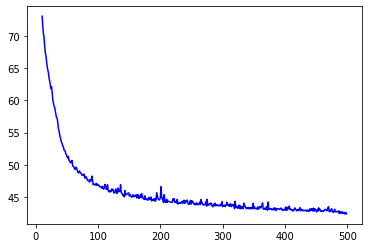

In [33]:
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label = 'Training loss')
plt.show()

In [34]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time - window_size:]
results = np.array(forecast)[:, 0, 0]

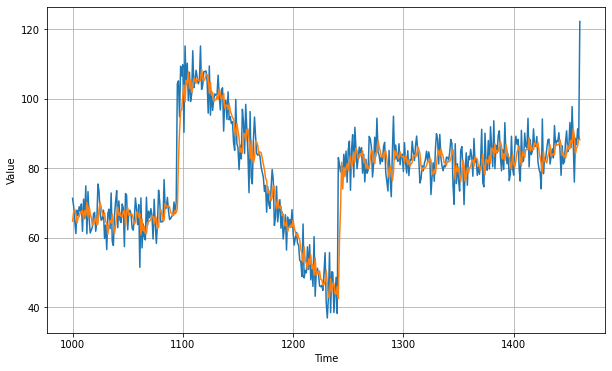

In [35]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [36]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.8349247